In [ ]:
# General Imports
import os
import imagehash
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from math import inf as INFINITE

# PyTorch Imports
import torch
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# Huggingface Imports
from datasets import load_dataset, concatenate_datasets, ClassLabel

# Dataset Used
- https://huggingface.co/datasets/Simezu/brain-tumour-MRI-scan [huggingface] - 5.71k - 1.31k
- https://huggingface.co/datasets/PranomVignesh/MRI-Images-of-Brain-Tumor [huggingface] - 3.76k - 1.6k
- https://huggingface.co/datasets/rhyssh/Brain-Tumor-MRI-Dataset-Training - 800

In [ ]:
# Load the dataset
ds1 = load_dataset("Simezu/brain-tumour-MRI-scan")
ds2 = load_dataset("PranomVignesh/MRI-Images-of-Brain-Tumor")
ds3 = load_dataset("rhyssh/Brain-Tumor-MRI-Dataset-Training")

In [1]:
def harmonize_labels(x, name):
    if name == "ds1":
        label_map = {
            "1-notumor": "notumor", "2-glioma": "glioma", "3-meningioma": "meningioma", "4-pituitary": "pituitary"
        }
    else:
        label_map = {
            "no-tumor": "notumor", "glioma": "glioma", "meningioma": "meningioma", "pituitary": "pituitary"
        }
    x["label"] = label_map.get(x["label"], x["label"])
    return x

# Apply label harmonization on ds1
ds1 = ds1.map(harmonize_labels, "ds1")
ds1 = ds1.cast_column("label", ClassLabel(names=["glioma", "meningioma", "notumor", "pituitary"]))

# Apply label harmonization on ds2
ds2 = ds2.map(harmonize_labels, "ds2")
ds2 = ds2.cast_column("label", ClassLabel(names=["glioma", "meningioma", "notumor", "pituitary"]))

df_train = concatenate_datasets([ds1["train"], ds2["train"], ds3["train"]])
df_test = concatenate_datasets([ds1["test"], ds2["test"], ds2["validation"]])

# Convert to pandas DF
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Check for duplicates and remove
def image_hash(image_path):
    return str(imagehash.average_hash(Image.open(image_path["path"])))

def remove_duplicates(df):
    df["image_hash"] = df["image"].apply(image_hash)
    df_dedup = df.drop_duplicates(subset="image_hash")
    print(f"Removed {len(df) - len(df_dedup)} duplicates")
    return df_dedup.drop(columns="image_hash")

def remove_test_from_train(df_train, df_test):
    train_hashes = set(df_train["image"].apply(image_hash))
    test_hashes = set(df_test["image"].apply(image_hash))
    common_hashes = train_hashes.intersection(test_hashes)

    df_train_clean = df_train[~df_train["image"].apply(image_hash).isin(common_hashes)]
    print(f"Removed {len(df_train) - len(df_train_clean)} images from train set that were present in test set")
    return df_train_clean

df_train = remove_duplicates(df_train)
df_test = remove_duplicates(df_test)

df_train = remove_test_from_train(df_train, df_test)

print(f"Train: {len(df_train)}")
print(f"Test: {len(df_test)}")
print(f"Train/Test Ratio: {len(df_train) / (len(df_train) + len(df_test)):.2f}")

Removed 2632 duplicates
Removed 433 duplicates
Removed 506 images from train set that were present in test set
Train: 2574
Test: 878
Train/Test Ratio: 0.75


# Exploratory Data Analysis (EDA)
- Check Data Type : ["image", "label"]
- Plot Bar Graphs of Unique Values : Balanced
- Sample and Check Images : Grayscale

In [2]:
def column_summary(df: pd.DataFrame) -> pd.DataFrame:
    summary_data = []

    for col_name in df.columns:

        col_dtype = df[col_name].dtype
        n_nulls = df[col_name].isnull().sum()
        n_not_nulls = df[col_name].notnull().sum()
        if (df[col_name].dtype == "object"):
            n_distinct = None
            distinct_value_counts = None

        else:
            n_distinct = df[col_name].nunique()
            if n_distinct <= 10:
                distinct_value_counts = df[col_name].value_counts().to_dict()
            else:
                distinct_value_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_value_counts = {k: v for k, v in sorted(distinct_value_counts.items(), key=lambda item: item[1], reverse=True)}

        summary = {
            "dtype": col_dtype,
            "n_null": n_nulls,
            "n_not_null": n_not_nulls,
            "n_distinct": n_distinct,
            "distinct": distinct_value_counts
        }
        summary_data.append(summary)

    summary_df = pd.DataFrame(summary_data, index=df.columns)
    return summary_df

print(column_summary(df_train))
print(column_summary(df_test))

        dtype  n_null  ...  n_distinct                          distinct
image  object       0  ...         NaN                              None
label   int64       0  ...         4.0  {3: 859, 2: 692, 1: 673, 0: 350}

[2 rows x 5 columns]
        dtype  n_null  ...  n_distinct                          distinct
image  object       0  ...         NaN                              None
label   int64       0  ...         4.0  {2: 230, 3: 224, 0: 218, 1: 206}

[2 rows x 5 columns]


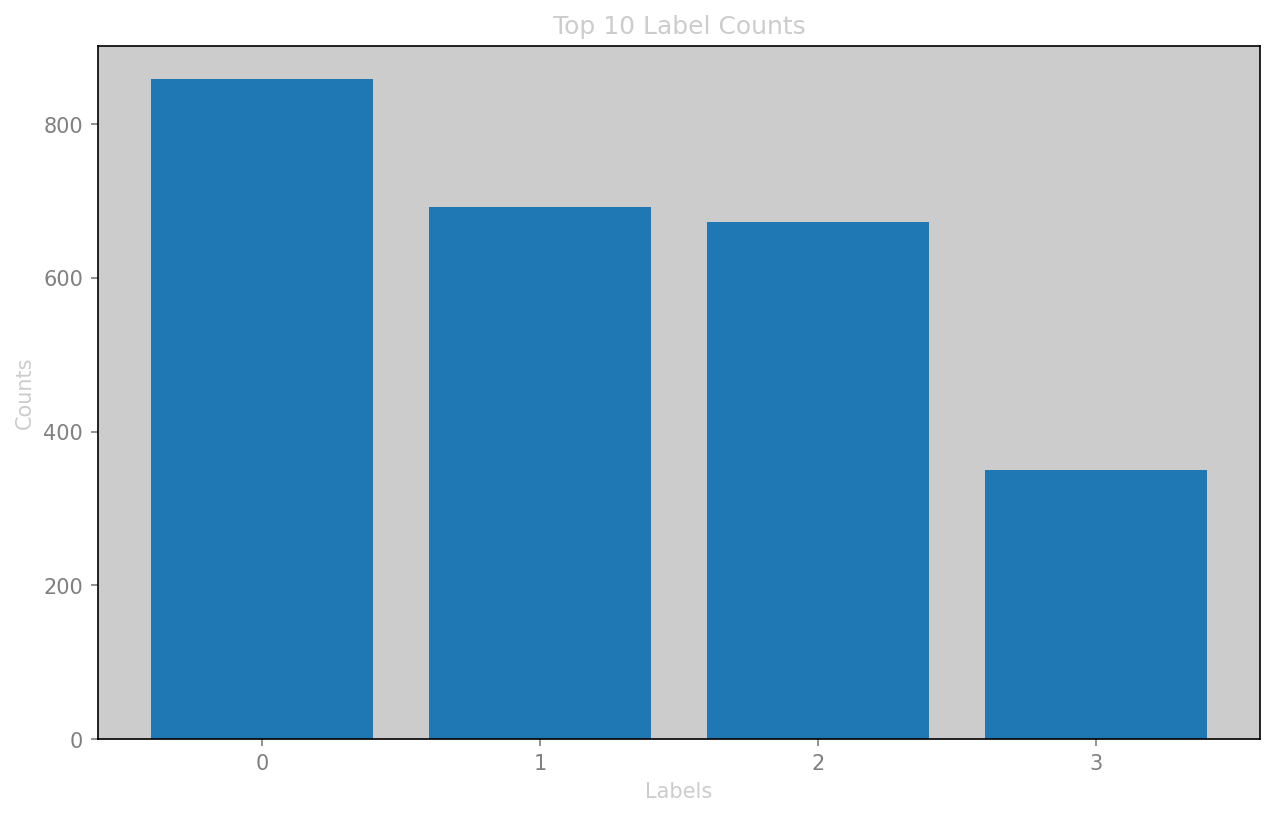

In [3]:
value_counts = df_train["label"].value_counts().head(10).to_dict()
k = [str(s) for s in list(value_counts.keys())]
k = sorted(k, key=lambda item: int(item))
v = list(value_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(k, v)
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Top 10 Label Counts")
plt.show()

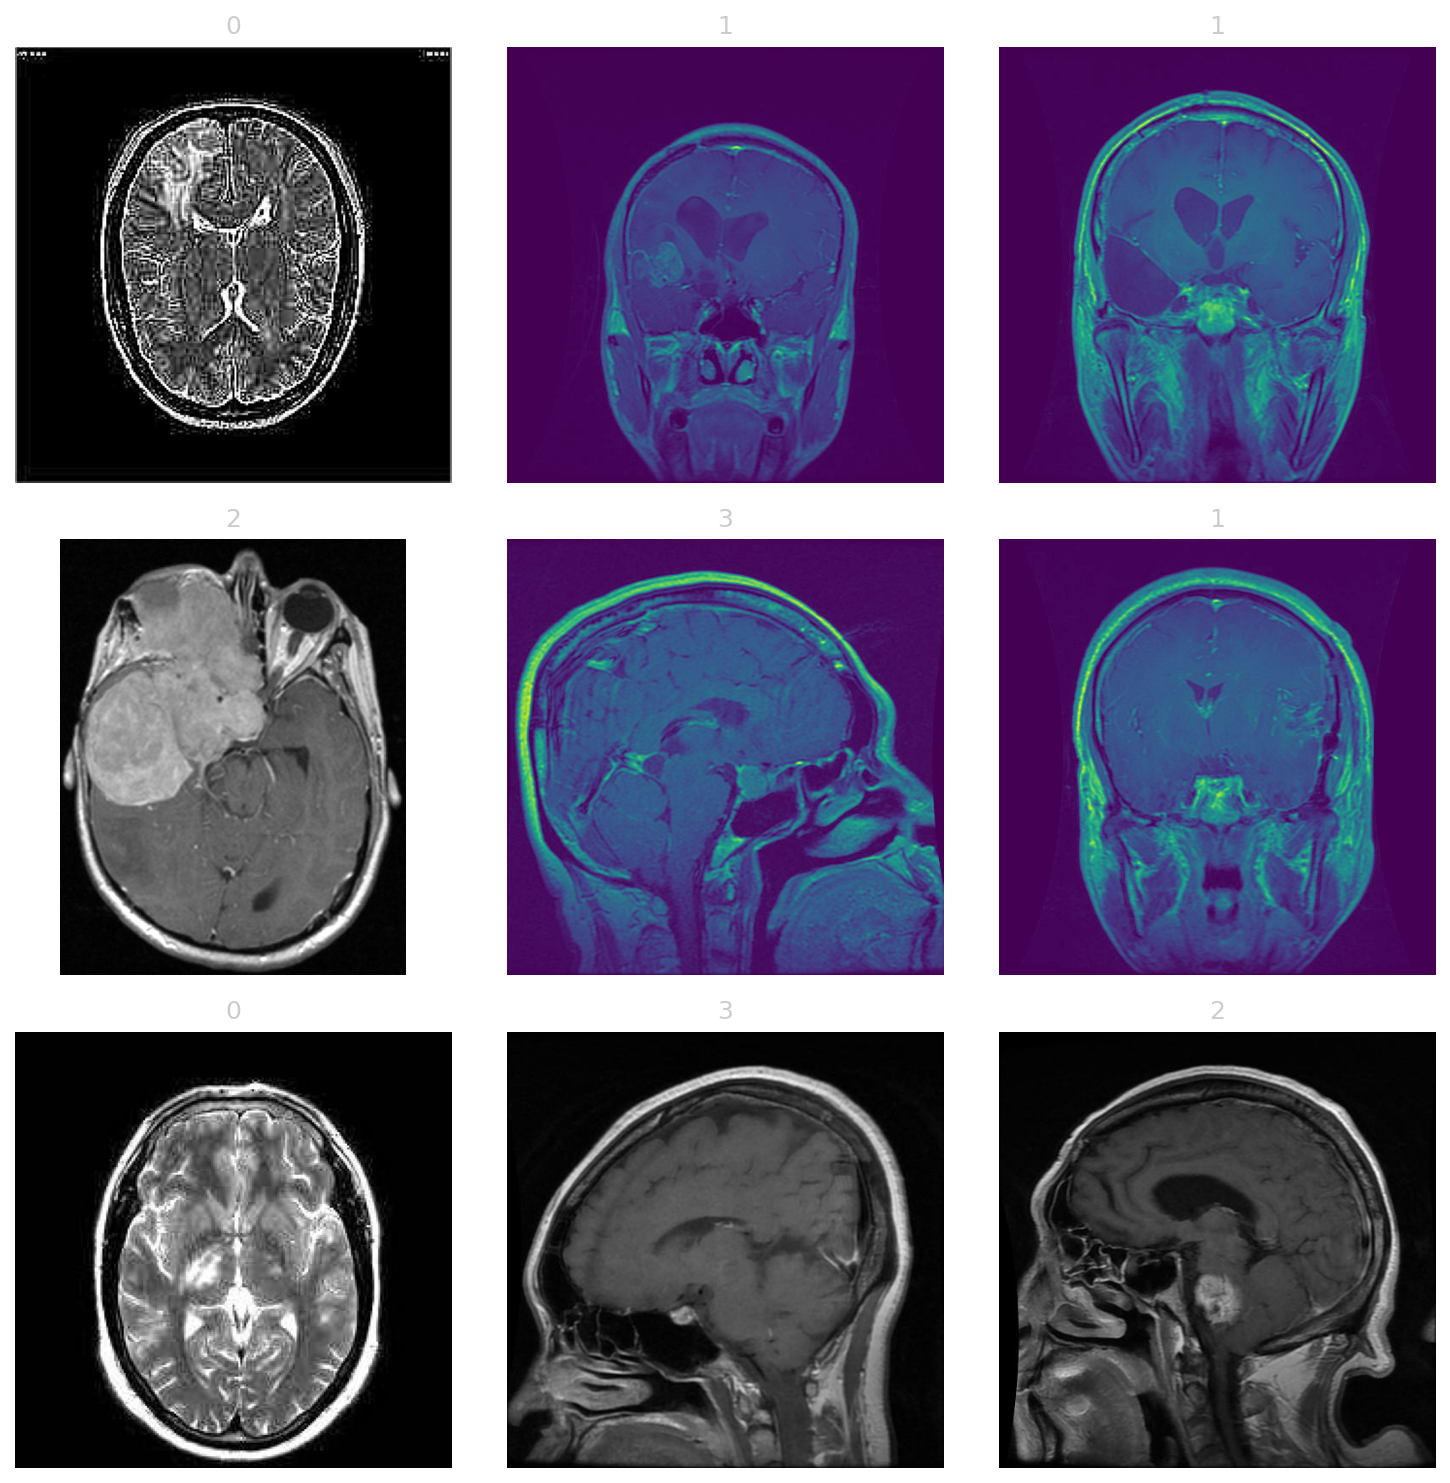

In [4]:
sample_images = df_train.sample(9)
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for ax, (img_path, label) in zip(axes.flatten(), sample_images.itertuples(index=False)):
    img = Image.open(img_path["path"])
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()
plt.show()

# Custom Dataset Definition
- Define a Custom Dataset Class
- Create DataLoaders

In [ ]:
class TumorDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform: bool = None) -> None:
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]["path"]
        label = self.df.iloc[idx, 1]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TumorDataset(df_train, transform)
test_dataset = TumorDataset(df_test, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Finetuning
- Use Resnet50 and Modify input and output feature count in fc

In [ ]:
model = models.resnet50(pretrained=True)

n_classes = len(df_train["label"].unique())
model.fc = torch.nn.Linear(model.fc.in_features, n_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Training Loop

In [5]:
def get_best_loss():
    losses = []
    for file in os.listdir():
        if file.startswith("model-") and file.endswith(".pth"):
            losses.append(float(file.split("-")[1].split(".pth")[0]))
    if not len(losses):
        return INFINITE
    return max(losses)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f"Epoch: {epoch+1}")
    print(f"\tTrain Loss: {train_loss:.4f}")

    model.eval()
    test_loss = 0.0
    test_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    print(f"\tTest Loss: {test_loss:.4f}")
    print(f"\tTest Accuracy: {100*test_correct/total:.2f}%")

    if (test_loss < get_best_loss()):
        model_path = f"model-{test_loss}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}")
    print()

Epoch: 1
	Train Loss: 13.3563
	Test Loss: 14.4825
	Test Accuracy: 84.05%
Model saved at model-14.482503160834312.pth

Epoch: 2
	Train Loss: 6.4327
	Test Loss: 85.0970
	Test Accuracy: 47.38%

Epoch: 3
	Train Loss: 8.9698
	Test Loss: 23.7734
	Test Accuracy: 83.14%

Epoch: 4
	Train Loss: 4.7807
	Test Loss: 34.7951
	Test Accuracy: 75.40%

Epoch: 5
	Train Loss: 6.3419
	Test Loss: 118.9632
	Test Accuracy: 37.24%

Epoch: 6
	Train Loss: 4.5688
	Test Loss: 34.5677
	Test Accuracy: 74.37%

Epoch: 7
	Train Loss: 7.6812
	Test Loss: 24.9749
	Test Accuracy: 79.73%

Epoch: 8
	Train Loss: 5.2338
	Test Loss: 20.6811
	Test Accuracy: 84.05%

Epoch: 9
	Train Loss: 3.9198
	Test Loss: 32.2961
	Test Accuracy: 77.90%

Epoch: 10
	Train Loss: 2.8604
	Test Loss: 37.4675
	Test Accuracy: 76.08%

